# IBM watsonx.governance evaluation of Tool Calling Agent developed using Langgraph

This notebook demonstrates how to use the Tool calling hallucination evaluator from IBM watsonx.governance for governing your applications right in your development environment.

The sample app shown here is an Agentic RAG example which uses the tools get_current_weather, fetch_stock_price to respond to the user queries. 

### Install the dependencies

In [ ]:
%pip install --quiet "ibm-watsonx-gov[agentic, visualization]" ibm-watsonx-ai langchain-community langchain_ibm pyppeteer nest_asyncio

### Accept the credentials
The following code snippet ensures that specific environment variables are set without being hardcoded in the script. It does so by prompting the user for input only if the variables are not already set.

The environment variables need to be set are:

1. **WATSONX_PROJECT_ID:** This is required to use the watsonx.ai. You can either create a new project by following this [documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/projects.html?context=wx&audience=wdp#create-a-project), or use an existing one. To find the project ID, navigate to the **Manage** section of the chosen project and copy it from the **General** details.
 
2. **WATSONX_APIKEY:** This is required to use the watsonx.ai and IBM watsonx.governance capabilities. Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

Optionally, if you are using IBM watsonx.governance or watsonx.ai as a service in a regional data center other than Dallas (us-south), in Texas US, you need to set the appropriate environment variables: WXG_URL for watsonx.governance and WATSONX_URL for watsonx.ai. You can check the regional availability of watsonx services [here](https://www.ibm.com/docs/en/watsonx/saas?topic=integrations-regional-availability-cloud#regional-availability-of-the-watsonx-services)

Additionally, if you have multiple service instances of watsonx.governance, set the desired service instance ID as an environment variable using **WXG_SERVICE_INSTANCE_ID**.

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("WATSONX_PROJECT_ID")
_set_env("WATSONX_APIKEY")

WATSONX_PROJECT_ID:  ········
WATSONX_APIKEY:  ········


### Set up the Watsonx LLM model
In this section, we initialize the ChatWatsonx from the langchain_ibm package to use IBM's Granite language model (granite-3-2b-instruct) for text generation.
Environment variables are used to securely access the IBM Watsonx platform:

- WATSONX_URL: Base URL for the Watsonx service.
- WATSONX_APIKEY: API key for authentication.
- WATSONX_PROJECT_ID: ID of the Watsonx project to scope resources

In [2]:
from langchain_ibm import ChatWatsonx
import os

llm = ChatWatsonx(
    model_id="ibm/granite-3-2b-instruct",
    url=os.getenv("WATSONX_URL", "https://us-south.ml.cloud.ibm.com"),
    apikey=os.getenv("WATSONX_APIKEY"),
    project_id=os.getenv("WATSONX_PROJECT_ID"),
    params={
        "decoding_method": "greedy",
        "temperature": 0,
        "min_new_tokens": 5,
        "max_new_tokens": 250,
        "stop_sequences": ["Human:", "Observation:"],
    },
)

### Defining Tools for the Agent
This cell sets up custom tools that the agent can call during execution. Each tool wraps a specific Python function and provides a structured interface for interaction within the graph

In [3]:
from langchain.tools import tool
from enum import Enum
import random

# 1. Enum for allowed cities
class City(str, Enum):
    barcelona = "Barcelona"
    delhi = "Delhi"
    new_york = "New York"
    tel_aviv = "Tel Aviv"


# 2. Tool functions
@tool
def get_weather(city: City) -> dict:
    """Returns the weather in Celsius for a given city.
    
    Args:
         city: A given city name. Allowed values are: Barcelona, Delhi, New York, Tel Aviv.

    Returns:
         The weather in the given city in celsius."""
    mock_data = {
        City.barcelona: {
            "temperature_celsius": 23,
            "description": "Partly cloudy",
            "humidity": 60
        },
        City.delhi: {
            "temperature_celsius": 35,
            "description": "Hot and dry",
            "humidity": 25
        },
        City.new_york: {
            "temperature_celsius": 18,
            "description": "Rainy",
            "humidity": 75
        },
        City.tel_aviv: {
            "temperature_celsius": 26,
            "description": "Sunny",
            "humidity": 55
        }
    }

    return {"city": city.value, **mock_data[city]}
    
@tool
def fetch_stock_price(symbol: str, date:str):
    """Fetch the current stock price for a given symbol."""
    # Simulate API call
    # Generate a realistic price (between $1 and $1000)
    base_price = random.uniform(1, 1000)
    fluctuation = random.uniform(-0.05, 0.05)  # -5% to +5%
    price = round(base_price * (1 + fluctuation), 2)
    return f"The current price of {symbol} is ${price:.2f}"

tools = [fetch_stock_price, get_weather]

### Binding the Language Model with Tool Specifications

In [4]:
llm_with_tools = llm.bind_tools(tools)

### Set up the State

In [5]:
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from typing import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        input_text (str): 
            The user's raw input query or question. 
        record_id (Optional[str]): 
            Unique identifier for the record.            
        generated_text (Optional[str]): 
            The final output generated by the LLM after processing all contexts.
        tool_calls (list):
            The list of tools invoked for a user query
        messages (list):
            List of messages required for the LLM
    """
    messages: list #List of messages required for the LLM
    input_text: str #The user's raw input query or question
    tool_calls: list #The list of tools invoked for a user query
    record_id: str #Unique identifier for the record.
    generated_text: str #The final output generated by the LLM after processing

#### Initialise the evaluator

In [6]:
from ibm_watsonx_gov.evaluate.agentic_evaluation import AgenticEvaluation

evaluator = AgenticEvaluation()

### Build your langgraph application

#### Define LLM Agent Node

Define the logic for invoking the agent within a LangGraph node. It takes the current GraphState and RunnableConfig as input. It invokes the `llm_with_tools ` with the user's input text.

Extracts the tools used during the agent's reasoning process.
Formats the tool usage into a structured list for further analysis or visualization.

Returns the list of tools used, the raw response messages, and a placeholder for generated text.

The `llm_agent` node defined below is decorated with IBM watsonx.governance evaluator `evaluate_tool_calling_hallucination` tool to compute the Tool Calling Hallucination metric. This node reads the user query from the `input_text` attribute from the application state and writes the list of tools invoked into the `tool_calls` attribute and the AIMessage response to the `messages` and set back to the application state.

In [8]:
from ibm_watsonx_gov.config import AgenticAIConfiguration
from langgraph.config import RunnableConfig

In [9]:
import json

tool_calling_hallucination_config={
    "question_field": "input_text", 
    "record_id_field": "record_id", 
    "tool_calls_field":"tool_calls",
    "tools":tools
}

@evaluator.evaluate_tool_calling_hallucination(configuration=AgenticAIConfiguration(**tool_calling_hallucination_config))
def llm_agent(state: GraphState, config: RunnableConfig):
    
    user_query = state["input_text"]
    response = llm_with_tools.invoke([HumanMessage(user_query)])
    tool_calls = response.tool_calls if hasattr(response, 'tool_calls') else []

    return {
        "messages": [response],
        "tool_calls": response
    }

### Adding a Router Function to Check Tool Calling Hallucination
- The tools_condition function evaluates the agent's response and check for the tool calling hallucination score.
- If the score is 1, the workflow proceeds to the Generate Response with a default response.
- If the score is 0, the workflow reroutes to the Tools Node to execute the selected tool.

In [10]:
def tools_condition(state: GraphState, config: RunnableConfig):
    metrics = evaluator.get_metric_results(node_name="llm_agent", metric_name="tool_calling_hallucination")
    if not metrics:
        return "Hallucinated"

    latest_metric = metrics[-1]
    if latest_metric.value == 1:
        return "Hallucinated"

    return "Not Hallucinated"

### Define Answer generation node
This node generates the final answer based on the tool execution results, if available; otherwise, it returns a default response.

In [11]:
def generate_response(state: GraphState, config: RunnableConfig):
    tool_results = "\n".join(
        [msg.content for msg in state["messages"] if isinstance(msg, ToolMessage)]
    )
    if not tool_results:
        tool_results = "I'm sorry, but the agent couldn't process your query. Please try rephrasing or providing more details so I can better assist you."
    return {
        "messages": [AIMessage(content=f"Final Answer:\n{tool_results}")],
        "generated_text": tool_results
    }

#### Assemble your application

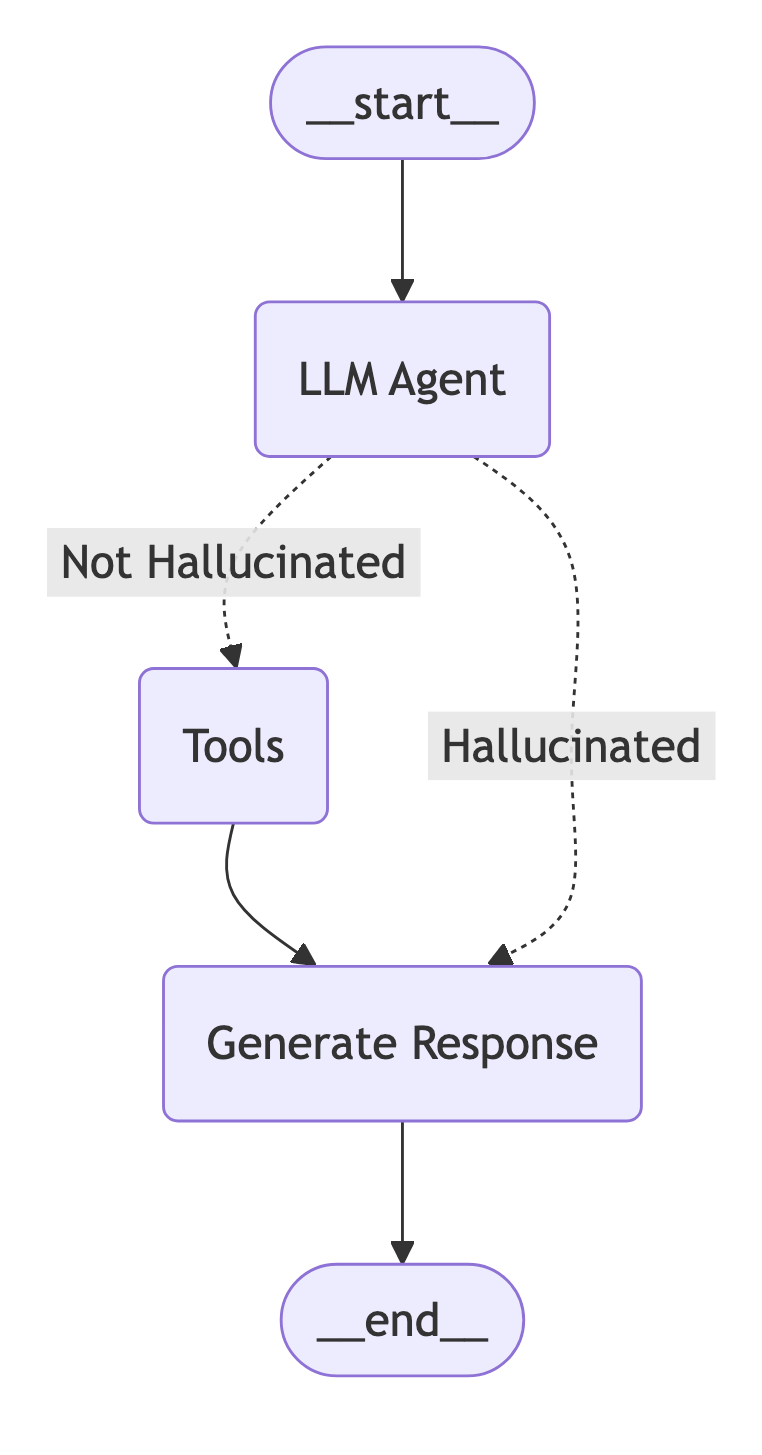

In [12]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode


graph = StateGraph(GraphState)

graph.add_node("LLM Agent", llm_agent)
graph.add_node("Generate Response", generate_response)
graph.add_node("Tools", ToolNode(tools))

graph.set_entry_point("LLM Agent")
graph.add_conditional_edges(
    "LLM Agent",
    tools_condition,
    {"Not Hallucinated": "Tools", "Hallucinated": "Generate Response"}
)
graph.add_edge("Tools", "Generate Response")
graph.add_edge("Generate Response", END)

# Compile the graph
rag_app = graph.compile()

# Show
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(
    Image(
        rag_app.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.NATURAL,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=5,
        ),
        width=300,  # Image width in pixels
        height=200  # Image height in pixels
    )
)

### Do a single invocation

Now the application is invoked for a single row of data. You will see a new key as the input:
1. `record_id`: This is required so that IBM watsonx.governance can keep track of individual rows and associate metrics with each row. This will become evident when we do batch invocation in the next cell.

In [13]:
result = rag_app.invoke({"input_text": "What’s the weather in Mumbai location today", "record_id":"1"})

### Prepare the app results
By default, the metric result will only include the `record_id` column from the input data.  
If you want to include additional data like input, output or ground_truth, you can specify them in the `input_data` parameter.

In [14]:
import pandas as pd

result_df = pd.DataFrame([result])
input_data = result_df[["input_text", "record_id", "generated_text"]] # Add the columns which should be part of the application metric results
metric_result = evaluator.get_metrics_df(input_data=input_data)

### Display the metric results

In [15]:
from ibm_watsonx_gov.visualizations.visualization_utils import display_table

display_table(metric_result)

ITable(caption='Records', classes='display nowrap compact violations_table', style='table-layout:auto;width:au…

### Fetch the metric details for the agent

In [16]:
metrics = evaluator.get_metric_results(node_name="llm_agent", metric_name="tool_calling_hallucination")

In [17]:
metrics

[ToolMetricResult(name='tool_calling_hallucination', method='static_evaluator', provider='TOOL_CALLING_HALLUCINATION', value=1.0, errors=None, additional_info={'explanations': [{'hallucinations': [{'hallucination_type': 'Allowed values', 'explanation': "Values that are not allowed in city are: ['Mumbai']"}], 'value': 1.0, 'tool_name': 'get_weather'}]}, group=None, record_id='1', record_timestamp=None, tool_name='llm_agent', execution_count=1)]

Developed by [Salman Khan S](https://ibm.enterprise.slack.com/team/U05N5D76GQL)